<a href="https://colab.research.google.com/github/Oliwer-Krupa/Automatic-Number-Plate-Recognition/blob/main/lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wstęp

Metody uczenia maszynowego możemy podzielić na dwie główne kategorie (pomijając uczenie ze wzmocnieniem): nadzorowane i nienadzorowane. Uczenie **nadzorowane** (ang. *supervised*) to jest uczenie z dostępnymi etykietami dla danych wejściowych. Na parach danych uczących $dataset= \{(x_0,y_0), (x_1,y_1), \ldots, (x_n,y_n)\}$ model ma za zadanie nauczyć się funkcji $f: X \rightarrow Y$. Z kolei modele uczone w sposób **nienadzorowany** (ang. *unsupervised*) wykorzystują podczas trenowania dane nieetykietowane tzn. nie znamy $y$ z pary $(x, y)$.

Dość częstą sytuacją, z jaką mamy do czynienia, jest posiadanie małego podziobioru danych etykietowanych i dużego nieetykietowanych. Często annotacja danych wymaga ingerencji człowieka - ktoś musi określić co jest na obrazku, ktoś musi powiedzieć czy dane słowo jest rzeczownkiem czy czasownikiem itd.

Jeżeli mamy dane etykietowane do zadania uczenia nadzorowanego (np. klasyfikacja obrazka), ale także dużą ilość danych nieetykietowanych, to możemy wtedy zastosować techniki **uczenia częściowo nadzorowanego** (ang. *semi-supervised learning*). Te techniki najczęściej uczą się funkcji $f: X \rightarrow Y$, ale jednocześnie są w stanie wykorzystać informacje z danych nieetykietowanych do poprawienia działania modelu.

## Cel ćwiczenia

Celem ćwiczenia jest nauczenie modelu z wykorzystaniem danych etykietowanych i nieetykietowanych ze zbioru STL10 z użyciem metody [Bootstrap your own latent](https://arxiv.org/abs/2006.07733).

Metoda ta jest relatywnie "lekka" obliczeniowo, a także dość prosta do zrozumienia i zaimplementowania, dlatego też na niej się skupimy na tych laboratoriach.

# Zbiór STL10

Zbiór STL10 to zbiór stworzony i udostępniony przez Stanford [[strona]](https://ai.stanford.edu/~acoates/stl10/) [[papier]](https://cs.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf) a inspirowany przez CIFAR-10. Obrazy zostały pozyskane z [ImageNet](https://image-net.org/). Szczegóły można doczytać na ich stronie. To co jest ważne to to, że autorzy zbioru dostarczają predefiniowany plan eksperymentalny, żeby móc porównywać łatwo wyniki eksperymentów. Nie będziemy go tutaj stosować z uwagi na jego czasochłonność (10 foldów), ale warto pamiętać o tym, że często są z góry ustalone sposoby walidacji zaprojetowanych przez nas algorytmów na określonych zbiorach referencyjnych.

Korzystając z `torchvision.datasets` ***załaduj*** 3 podziały zbioru danych STL10: `train`, `test`, `unlabeled` oraz utwórz z nich instancje klasy `DataLoader`. Korzystając z Google Colab rozważ użycie Google Drive do przechowyania zbioru w calu zaoszczędzenia czasu na wielokrotne pobieranie.

In [2]:
# Krok 1: Importowanie bibliotek i montowanie Google Drive
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from google.colab import drive
from torchvision.models import resnet18
from torch import cuda, device
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Montowanie Google Drive
drive.mount('/content/drive')

# Krok 2: Definiowanie transformacji danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Krok 3: Ładowanie zbioru danych STL10
data_dir = '/content/drive/MyDrive/STL10'

train_dataset = STL10(root=data_dir, split='train', download=True, transform=transform)
test_dataset = STL10(root=data_dir, split='test', download=True, transform=transform)
unlabeled_dataset = STL10(root=data_dir, split='unlabeled', download=True, transform=transform)

# Krok 4: Tworzenie instancji DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Sprawdzanie rozmiarów danych
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Unlabeled dataset size: {len(unlabeled_dataset)}")


Mounted at /content/drive
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 5000
Test dataset size: 8000
Unlabeled dataset size: 100000


# Uczenie nadzorowane

Żeby porównać czy metoda BYOL przynosi nam jakieś korzyści musimy wyznaczyć wartość bazową metryk(i) jakości, których będziemu używać (np. dokładność).

***Zaimplementuj*** wybraną metodę uczenia nadzorowanego na danych `train` z STL10. Możesz wykorzystać predefiniowane architektury w `torchvision.models` oraz kody źródłowe z poprzednich list.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torchvision import models
from tqdm import tqdm

# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Definiowanie transformacji danych
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ładowanie zbioru danych STL10
data_dir = '/content/drive/MyDrive/STL10'

train_dataset = STL10(root=data_dir, split='train', download=True, transform=transform)
test_dataset = STL10(root=data_dir, split='test', download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Definiowanie modelu
model = models.resnet18(pretrained=False, num_classes=10)
model = model.cuda()

# Definiowanie funkcji straty i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Funkcja treningowa
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}')
    return epoch_loss

# Funkcja ewaluacji
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Trening modelu
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    test_accuracy = evaluate(model, test_loader)

print('Finished Training')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/40 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 40/40 [00:08<00:00,  4.69it/s]

Epoch 1, Loss: 1.8092


Test Accuracy: 31.00%


100%|██████████| 40/40 [00:07<00:00,  5.34it/s]

Epoch 2, Loss: 1.4154


Test Accuracy: 43.89%


100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

Epoch 3, Loss: 1.2107


Test Accuracy: 34.25%


100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

Epoch 4, Loss: 1.0442


Test Accuracy: 50.06%


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]

Epoch 5, Loss: 1.0416


Test Accuracy: 45.36%


100%|██████████| 40/40 [00:06<00:00,  6.09it/s]

Epoch 6, Loss: 0.9180


Test Accuracy: 58.29%


100%|██████████| 40/40 [00:06<00:00,  6.09it/s]

Epoch 7, Loss: 0.6803


Test Accuracy: 48.77%


100%|██████████| 40/40 [00:06<00:00,  5.96it/s]

Epoch 8, Loss: 0.6820


Test Accuracy: 52.76%


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]

Epoch 9, Loss: 0.5273


Test Accuracy: 56.19%


100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

Epoch 10, Loss: 0.4040


Test Accuracy: 56.12%


100%|██████████| 40/40 [00:08<00:00,  4.88it/s]

Epoch 11, Loss: 0.2429


Test Accuracy: 56.80%


100%|██████████| 40/40 [00:07<00:00,  5.30it/s]

Epoch 12, Loss: 0.1689


Test Accuracy: 53.69%


100%|██████████| 40/40 [00:06<00:00,  6.02it/s]

Epoch 13, Loss: 0.3387


Test Accuracy: 57.45%


100%|██████████| 40/40 [00:06<00:00,  6.03it/s]

Epoch 14, Loss: 0.1979


Test Accuracy: 58.89%


100%|██████████| 40/40 [00:06<00:00,  5.95it/s]

Epoch 15, Loss: 0.2129


Test Accuracy: 56.31%


100%|██████████| 40/40 [00:07<00:00,  5.08it/s]

Epoch 16, Loss: 0.1841


Test Accuracy: 57.17%


100%|██████████| 40/40 [00:08<00:00,  4.80it/s]

Epoch 17, Loss: 0.1957


Test Accuracy: 60.35%


100%|██████████| 40/40 [00:08<00:00,  4.90it/s]

Epoch 18, Loss: 0.2321


Test Accuracy: 60.01%


100%|██████████| 40/40 [00:06<00:00,  5.76it/s]

Epoch 19, Loss: 0.0693


Test Accuracy: 61.62%


100%|██████████| 40/40 [00:06<00:00,  5.97it/s]

Epoch 20, Loss: 0.1078


Test Accuracy: 60.94%
Finished Training


# Bootstrap your own latent

Metoda [Bootstrap your own latent](https://arxiv.org/abs/2006.07733) jest opisana w rodziale 3.1 papieru a także w dodatku A. Składa się z dwóch etapów:


1.   uczenia samonadzorowanego (ang. *self-supervised*)
2.   douczania nadzorowanego (ang. *fine-tuning*)

## Uczenie samonadzorowane

Architektura do nauczania samonadzorowanego składa się z dwóch sieci: (1) *online* i (2) *target*. W uproszczeniu cała architektura działa tak:


1.   Dla obrazka $x$ wygeneruj dwie różne augmentacje $v$ i $v'$ za pomocą funkcji $t$ i $t'$.
2.   Widok $v$ przekazujemy do sieci *online*, a $v'$ do *target*.
3.   Następnie widoki przekształacamy za pomocą sieci do uczenia reprezentacji (np. resnet18 lub resnet50) do reprezentacji $y_\theta$ i $y'_\xi$.
4.   Potem dokonujemy projekcji tych reprezentacji w celu zmniejszenia wymiarowości (np. za pomocą sieci MLP).
5.   Na sieci online dokonujmey dodatkowo predykcji pseudo-etykiety (ang. *pseudolabel*)
6.   Wyliczamy fukncję kosztu: MSE z wyjścia predyktora sieci *online* oraz wyjścia projekcji sieci *target* "przepuszczonej" przez predyktor sieci *online* **bez propagacji wstecznej** (*vide Algorithm 1* z papieru).
7.   Dokonujemy wstecznej propagacji **tylko** po sieci *online*.
8.   Aktualizujemy wagi sieci *target* sumując w ważony sposób wagi obu sieci $\xi = \tau\xi + (1 - \tau)\theta$ ($\tau$ jest hiperprametrem) - jest to ruchoma średnia wykładnicza (ang. *moving exponential average*).

Po zakończeniu procesu uczenia samonadzorowanego zostawiamy do douczania sieć kodera *online* $f_\theta$. Cała sieć *target* oraz warstwy do projekcji i predykcji w sieci *online* są "do wyrzucenia".

### Augmentacja

Dodatek B publikacji opisuje augmentacje zastosowane w metodzie BYOL. Zwróć uwagę na tabelę 6 w publikacji. `torchvision.transforms.RandomApply` może być pomocne.

***Zaimeplementuj*** augmentację $\tau$ i $\tau'$.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified


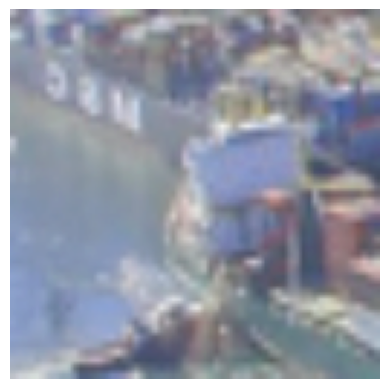

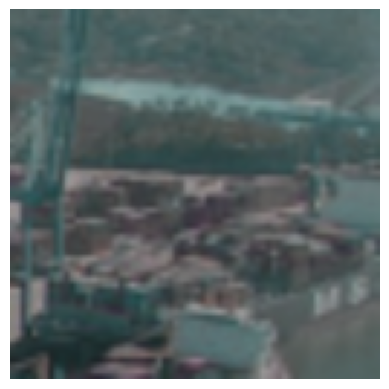

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive

# Montowanie Google Drive
drive.mount('/content/drive')

# Definiowanie augmentacji zgodnie z tabelą 6 w publikacji BYOL
class BYOLTransform:
    def __init__(self):
        self.base_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=128, scale=(0.2, 1.0)),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.final_transform = transforms.Compose([
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))], p=0.5),
        ])

    def __call__(self, x):
        x = self.base_transform(x)
        x = self.final_transform(x)
        return x

# Tworzenie instancji augmentacji
augmentation1 = BYOLTransform()
augmentation2 = BYOLTransform()

# Ładowanie zbioru danych STL10
data_dir = '/content/drive/MyDrive/STL10'

train_dataset = STL10(root=data_dir, split='train', download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Pobierz jeden obraz z zestawu danych
data_iter = iter(train_loader)
example_image, _ = next(data_iter)

# Przykład zastosowania augmentacji na obrazie
augmented_image1 = augmentation1(transforms.ToPILImage()(example_image[0]))
augmented_image2 = augmentation2(transforms.ToPILImage()(example_image[0]))

# Konwersja tensora do obrazu dla wizualizacji
def show_image(tensor_image):
    image = tensor_image.clone().detach().cpu().numpy()
    image = image.transpose(1, 2, 0)
    image = (image * 0.5) + 0.5
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Wyświetlenie obrazów po augmentacji
show_image(augmented_image1)
show_image(augmented_image2)


### Implementacja uczenia samonadzorowanego

***Zaprogramuj*** proces uczenia samonadzorowanego na danych nieetykietowanych ze zbioru STL10.

Wskazówki do realizacji polecenia:

1. Proces uczenia może trwać bardzo długo dlatego zaleca się zastsowanie wczesnego zatrzymania lub uczenia przez tylko jedną epokę. Mimo wszystko powinno się dać osiągnąć poprawę w uczeniu nadzorowanym wykorzystując tylko zasoby z Google Colab.
2. Dobrze jest pominąć walidację na zbiorze treningowym i robić ją tylko na zbiorze walidacyjnym - zbiór treningowy jest ogromny i w związku z tym narzut czasowy na walidację też będzie duży.
3. Walidację modelu można przeprowadzić na zbiorze `train` lub całkowicie ją pominąć, jeżeli uczymy na stałej ilości epok.
4. Rozważ zastosowanie tylko jednej augmentacji - augmentacja $\tau'$ jest bardziej czasochłonna niż $\tau$.
5. Poniżej jest zaprezentowany zalążek kodu - jest on jedynie wskazówką i można na swój sposób zaimplementować tę metodę

In [5]:
from copy import deepcopy
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import Tuple


class BYOL(nn.Module):
    def __init__(self, model, labels_no, tau = 0.999):
        super().__init__()
        self.encoder_online = model
        self.projector_online = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )
        self.predictor_online = nn.Linear(10, labels_no)

        self.encoder_target = deepcopy(self.encoder_online)
        self.projector_target = deepcopy(self.projector_online)

        self.tau = tau

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        q = self.encoder_online(x)
        z = self.projector_online(q)
        p = self.predictor_online(z)

        with torch.no_grad():
            z_prim = self.projector_target(self.encoder_target(x))

        return p, z_prim

    @torch.no_grad()
    def update_target_network(self) -> None:
        for online, target in zip(self.encoder_online.parameters(), self.encoder_target.parameters()):
            target.data = target.data * self.tau + online.data * (1 - self.tau)
        for online, target in zip(self.projector_online.parameters(), self.projector_target.parameters()):
            target.data = target.data * self.tau + online.data * (1 - self.tau)



In [6]:

def train_byol(model, train_loader, loss_fn, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for inputs, _ in tqdm(train_loader):
        inputs = inputs.cuda()

        # augment all inputs, store in tensor
        augm_1_batch = torch.stack([augm_1(inputs[i]) for i in range(len(inputs))]).cuda()

        optimizer.zero_grad()

        p, z_prim = model(augm_1_batch)
        loss = loss_fn(p, z_prim)
        loss.backward()
        optimizer.step()

        model.update_target_network()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}')
    return epoch_loss


In [8]:
from torchvision.transforms import RandomApply
import torch


augm_1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    RandomApply([transforms.RandomHorizontalFlip()], p=0.5),
    RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)], p=0.5),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augm_2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    RandomApply([transforms.RandomHorizontalFlip()], p=0.5),
    RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)], p=0.5),
    RandomApply(transforms.GaussianBlur(3, sigma=(0.1, 2.0)), p=0.1),
    RandomApply(transforms.RandomSolarize(0.5), p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [9]:
byol = BYOL(resnet18().cuda(), 10).cuda()
optimizer = Adam(byol.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_byol(byol, unlabeled_loader, loss_fn, optimizer, epoch)


100%|██████████| 1563/1563 [05:06<00:00,  5.10it/s]


Epoch 1, Loss: 0.0433


100%|██████████| 1563/1563 [05:05<00:00,  5.11it/s]


Epoch 2, Loss: 0.0221


100%|██████████| 1563/1563 [05:08<00:00,  5.07it/s]


Epoch 3, Loss: 0.0184


100%|██████████| 1563/1563 [05:08<00:00,  5.07it/s]


Epoch 4, Loss: 0.0208


100%|██████████| 1563/1563 [05:08<00:00,  5.07it/s]


Epoch 5, Loss: 0.0161


100%|██████████| 1563/1563 [05:07<00:00,  5.09it/s]


Epoch 6, Loss: 0.0218


100%|██████████| 1563/1563 [05:08<00:00,  5.07it/s]


Epoch 7, Loss: 0.0131


100%|██████████| 1563/1563 [05:08<00:00,  5.07it/s]


Epoch 8, Loss: 0.0136


100%|██████████| 1563/1563 [05:09<00:00,  5.05it/s]


Epoch 9, Loss: 0.0125


100%|██████████| 1563/1563 [05:09<00:00,  5.05it/s]

Epoch 10, Loss: 0.0109


## Douczanie nadzorowane

***Zaimplementuj*** proces douczania kodera z poprzedniego polecenia na danych etykietowanych ze zbioru treningowego. Porównaj jakość tego modelu z modelem nauczonym tylko na danych etykietownaych. Postaraj się wyjaśnić różnice.

In [10]:
state_dict = byol.encoder_online.state_dict()
encoder = resnet18().cuda()
encoder.load_state_dict(state_dict)

optimizer = Adam(encoder.parameters(), lr=1e-3)
loss_fn = CrossEntropyLoss()

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(encoder, train_loader, loss_fn, optimizer, epoch)
    test_accuracy = evaluate(encoder, test_loader)

100%|██████████| 5000/5000 [01:10<00:00, 70.77it/s]

Epoch 1, Loss: 2.5373


Test Accuracy: 10.11%


100%|██████████| 5000/5000 [01:09<00:00, 71.88it/s]

Epoch 2, Loss: 1.5521


Test Accuracy: 9.94%


100%|██████████| 5000/5000 [01:09<00:00, 71.78it/s]

Epoch 3, Loss: 1.2969


Test Accuracy: 10.21%


100%|██████████| 5000/5000 [01:10<00:00, 71.01it/s]

Epoch 4, Loss: 1.0681


Test Accuracy: 10.14%


100%|██████████| 5000/5000 [01:09<00:00, 71.88it/s]

Epoch 5, Loss: 0.8284


Test Accuracy: 13.68%


100%|██████████| 5000/5000 [01:10<00:00, 71.33it/s]

Epoch 6, Loss: 0.5752


Test Accuracy: 10.09%


100%|██████████| 5000/5000 [01:10<00:00, 71.00it/s]

Epoch 7, Loss: 0.3337


Test Accuracy: 11.62%


100%|██████████| 5000/5000 [01:11<00:00, 70.11it/s]

Epoch 8, Loss: 0.1921


Test Accuracy: 12.55%


100%|██████████| 5000/5000 [01:10<00:00, 71.07it/s]

Epoch 9, Loss: 0.1328


Test Accuracy: 11.57%


100%|██████████| 5000/5000 [01:10<00:00, 71.00it/s]

Epoch 10, Loss: 0.1049


Test Accuracy: 10.75%


100%|██████████| 5000/5000 [01:11<00:00, 70.19it/s]

Epoch 11, Loss: 0.0876


Test Accuracy: 10.68%


100%|██████████| 5000/5000 [01:09<00:00, 72.01it/s]

Epoch 12, Loss: 0.0838


Test Accuracy: 10.50%


100%|██████████| 5000/5000 [01:09<00:00, 71.74it/s]

Epoch 13, Loss: 0.0716


Test Accuracy: 13.46%


100%|██████████| 5000/5000 [01:09<00:00, 71.69it/s]

Epoch 14, Loss: 0.0593


Test Accuracy: 11.60%


100%|██████████| 5000/5000 [01:10<00:00, 71.19it/s]

Epoch 15, Loss: 0.0673


Test Accuracy: 11.66%


100%|██████████| 5000/5000 [01:09<00:00, 71.79it/s]

Epoch 16, Loss: 0.0622


Test Accuracy: 10.05%


100%|██████████| 5000/5000 [01:09<00:00, 71.79it/s]

Epoch 17, Loss: 0.0500


Test Accuracy: 10.26%


100%|██████████| 5000/5000 [01:10<00:00, 70.44it/s]

Epoch 18, Loss: 0.0482


Test Accuracy: 14.39%


100%|██████████| 5000/5000 [01:10<00:00, 71.20it/s]

Epoch 19, Loss: 0.0573


Test Accuracy: 10.11%


100%|██████████| 5000/5000 [01:10<00:00, 70.61it/s]

Epoch 20, Loss: 0.0392


Test Accuracy: 10.16%
